In [ ]:
import json
import os
import math
import librosa


In [ ]:
DATASET_PATH = "audio_dataset"
JSON_PATH = "data_12.json"
SAMPLE_RATE = 22050
TRACK_DURATION = 3 # measured in seconds
SAMPLES_PER_TRACK = SAMPLE_RATE * TRACK_DURATION

In [ ]:



def save_mfcc(dataset_path, json_path, num_mfcc=13, n_fft=2048, hop_length=512, num_segments=1):
    """Extracts MFCCs from music dataset and saves them into a json file along witgh genre labels.

        :param dataset_path (str): Path to dataset
        :param json_path (str): Path to json file used to save MFCCs
        :param num_mfcc (int): Number of coefficients to extract
        :param n_fft (int): Interval we consider to apply FFT. Measured in # of samples
        :param hop_length (int): Sliding window for FFT. Measured in # of samples
        :param: num_segments (int): Number of segments we want to divide sample tracks into
        :return:
        """

    # dictionary to store mapping, labels, and MFCCs
    data = {
        "mapping": [],
        "labels": [],
        "mfcc": []
    }

    samples_per_segment = int(SAMPLES_PER_TRACK / num_segments)
    num_mfcc_vectors_per_segment = math.ceil(samples_per_segment / hop_length)

    # loop through all genre sub-folder
    for i, (dirpath, dirnames, filenames) in enumerate(os.walk(dataset_path)):

        # ensure we're processing a genre sub-folder level
        if dirpath is not dataset_path:

            # save genre label (i.e., sub-folder name) in the mapping
            semantic_label = dirpath.split("/")[-1]
            data["mapping"].append(semantic_label)
            print("\nProcessing: {}".format(semantic_label))

            # process all audio files in genre sub-dir
            for f in filenames:

		# load audio file
                file_path = os.path.join(dirpath, f)
                signal, sample_rate = librosa.load(file_path, sr=SAMPLE_RATE)

                # process all segments of audio file
                for d in range(num_segments):

                    # calculate start and finish sample for current segment
                    start = samples_per_segment * d
                    finish = start + samples_per_segment

                    # extract mfcc
                    mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
                    mfcc = mfcc.T

                    # store only mfcc feature with expected number of vectors
                    if len(mfcc) == num_mfcc_vectors_per_segment:
                        data["mfcc"].append(mfcc.tolist())
                        data["labels"].append(i-1)
                        print("{},labels:{}, segment:{}".format(file_path,i-1, d+1))

    # save MFCCs to json file
    with open(json_path, "w") as fp:
        json.dump(data, fp, indent=4)
        


In [ ]:
if __name__ == "__main__":
    save_mfcc(DATASET_PATH, JSON_PATH)

In [81]:
import json
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow.keras as keras
import matplotlib.pyplot as plt

In [82]:
DATA_PATH = "data_12.json"

In [84]:
def load_data(data_path):
    """Loads training dataset from json file.
        :param data_path (str): Path to json file containing data
        :return X (ndarray): Inputs
        :return y (ndarray): Targets
    """

    with open(data_path, "r") as fp:
        data = json.load(fp)

    X = np.array(data["mfcc"])
    y = np.array(data["labels"])
    return X, y


In [85]:
def plot_history(history):
    """Plots accuracy/loss for training/validation set as a function of the epochs
        :param history: Training history of model
        :return:
    """

    fig, axs = plt.subplots(2)

    # create accuracy sublpot
    axs[0].plot(history.history["accuracy"], label="train accuracy")
    axs[0].plot(history.history["val_accuracy"], label="test accuracy")
    axs[0].set_ylabel("Accuracy")
    axs[0].legend(loc="lower right")
    axs[0].set_title("Accuracy eval")

    # create error sublpot
    axs[1].plot(history.history["loss"], label="train error")
    axs[1].plot(history.history["val_loss"], label="test error")
    axs[1].set_ylabel("Error")
    axs[1].set_xlabel("Epoch")
    axs[1].legend(loc="upper right")
    axs[1].set_title("Error eval")

    plt.show()

In [86]:
def prepare_datasets(test_size, validation_size):
    """Loads data and splits it into train, validation and test sets.
    :param test_size (float): Value in [0, 1] indicating percentage of data set to allocate to test split
    :param validation_size (float): Value in [0, 1] indicating percentage of train set to allocate to validation split
    :return X_train (ndarray): Input training set
    :return X_validation (ndarray): Input validation set
    :return X_test (ndarray): Input test set
    :return y_train (ndarray): Target training set
    :return y_validation (ndarray): Target validation set
    :return y_test (ndarray): Target test set
    """

    # load data
    X, y = load_data(DATA_PATH)

    # create train, validation and test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
    X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=validation_size)

    # add an axis to input sets
    X_train = X_train[..., np.newaxis]
    X_validation = X_validation[..., np.newaxis]
    X_test = X_test[..., np.newaxis]

    return X_train, X_validation, X_test, y_train, y_validation, y_test

In [113]:
def build_model(input_shape):
    """Generates CNN model
    :param input_shape (tuple): Shape of input set
    :return model: CNN model
    """

    # build network topology
    model = keras.Sequential()

    # 1st conv layer
    model.add(keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())

    # 2nd conv layer
    model.add(keras.layers.Conv2D(64, (3, 3), activation='sigmoid'))
    model.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())

    # 3rd conv layer
    model.add(keras.layers.Conv2D(32, (2, 2), activation='relu'))
    model.add(keras.layers.MaxPooling2D((2, 2), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())

    # flatten output and feed it into dense layer
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(64, activation='relu'))
    model.add(keras.layers.Dropout(0.3))

    # output layer
    model.add(keras.layers.Dense(6, activation='softmax'))

    return model

In [114]:
X_train, X_validation, X_test, y_train, y_validation, y_test = prepare_datasets(0.25, 0.2)

In [115]:
X_train


array([[[[-2.69836975e+02],
         [ 1.04356415e+02],
         [-1.56056442e+01],
         ...,
         [ 4.72540855e+00],
         [ 9.43701267e+00],
         [ 4.58149719e+00]],

        [[-2.66564453e+02],
         [ 1.08973045e+02],
         [-1.70234089e+01],
         ...,
         [ 7.00400496e+00],
         [ 8.59969711e+00],
         [ 1.22586644e+00]],

        [[-2.67982513e+02],
         [ 1.13296295e+02],
         [-2.32095757e+01],
         ...,
         [ 8.25571823e+00],
         [ 4.67916775e+00],
         [-1.71706271e+00]],

        ...,

        [[-2.32984512e+02],
         [ 1.17082428e+02],
         [-1.80646591e+01],
         ...,
         [-1.88937926e+00],
         [ 1.36506786e+01],
         [ 5.48519516e+00]],

        [[-1.83672363e+02],
         [ 6.53141251e+01],
         [ 4.57911587e+00],
         ...,
         [-2.80348563e+00],
         [ 9.33787441e+00],
         [-2.59909582e+00]],

        [[-1.50510101e+02],
         [ 3.06687031e+01],
         [

In [116]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

In [117]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation,Dense,Flatten,BatchNormalization,Conv2D,MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy

In [118]:
input_shape = (X_train.shape[1], X_train.shape[2], 1)
model = build_model(input_shape)

In [119]:
input_shape

(87, 13, 1)

In [120]:
optimiser = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimiser,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 85, 11, 32)        320       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 43, 6, 32)        0         
 g2D)                                                            
                                                                 
 batch_normalization_12 (Bat  (None, 43, 6, 32)        128       
 chNormalization)                                                
                                                                 
 conv2d_13 (Conv2D)          (None, 41, 4, 64)         18496     
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 21, 2, 64)        0         
 g2D)                                                            
                                                      

In [121]:
history = model.fit(X_train, y_train, validation_data=(X_validation, y_validation), batch_size=32, epochs=108)

Epoch 1/108
11/11 [==============================] - 3s 102ms/step - loss: 2.4559 - accuracy: 0.1667 - val_loss: 2.3525 - val_accuracy: 0.0976
Epoch 2/108
11/11 [==============================] - 1s 61ms/step - loss: 2.1339 - accuracy: 0.2191 - val_loss: 2.2989 - val_accuracy: 0.0976
Epoch 3/108
11/11 [==============================] - 1s 61ms/step - loss: 1.7997 - accuracy: 0.2901 - val_loss: 2.2420 - val_accuracy: 0.0976
Epoch 4/108
11/11 [==============================] - 1s 60ms/step - loss: 1.7759 - accuracy: 0.3148 - val_loss: 2.1882 - val_accuracy: 0.0976
Epoch 5/108
11/11 [==============================] - 1s 61ms/step - loss: 1.6105 - accuracy: 0.3827 - val_loss: 2.1079 - val_accuracy: 0.0976
Epoch 6/108
11/11 [==============================] - 1s 60ms/step - loss: 1.4385 - accuracy: 0.4444 - val_loss: 2.0316 - val_accuracy: 0.0976
Epoch 7/108
11/11 [==============================] - 1s 63ms/step - loss: 1.4128 - accuracy: 0.4722 - val_loss: 1.9672 - val_accuracy: 0.1098
Epoch

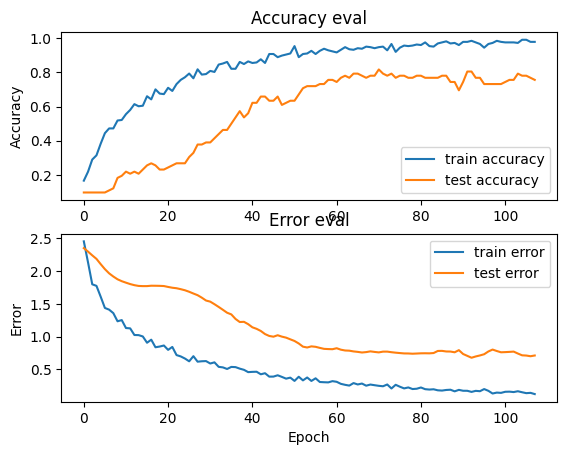

In [122]:
plot_history(history)

In [123]:
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print('\nTest accuracy:', test_acc)

5/5 - 0s - loss: 0.6853 - accuracy: 0.7868 - 146ms/epoch - 29ms/step

Test accuracy: 0.7867646813392639


In [124]:
X_to_predict = X_test[100]
y_to_predict = y_test[100]

In [125]:
def predict(model, X, y):
    """Predict a single sample using the trained model
    :param model: Trained classifier
    :param X: Input data
    :param y (int): Target
    """

    # add a dimension to input data for sample - model.predict() expects a 4d array in this case
    X = X[np.newaxis, ...] # array shape (1, 130, 13, 1)

    # perform prediction
    prediction = model.predict(X)

    # get index with max value
    predicted_index = np.argmax(prediction, axis=1)

    print("Target: {}, Predicted label: {}".format(y, predicted_index))

In [126]:
predict(model, X_to_predict, y_to_predict)

1/1 [==============================] - 0s 226ms/step
Target: 1, Predicted label: [1]


In [127]:
X_test.shape

(136, 87, 13, 1)

In [128]:
y_actual=y_test
y_pred=[]

In [129]:
for i in X_test:
  X = i
  X = X[np.newaxis, ...]
  prediction = model.predict(X)
  predicted_index = np.argmax(prediction, axis=1)
  y_pred=np.append(y_pred,predicted_index)

1/1 [==============================] - 0s 32ms/step


In [130]:
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt

In [131]:
cm=confusion_matrix(y_true=y_actual,y_pred=y_pred)

In [132]:
def plot_confusion_matrix(cm,classes,normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
   
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks,classes, rotation=45)
    plt.yticks(tick_marks,classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized Confusion Matrix")
    else:
        print('Confusion Matrix,without Normalization')
    print(cm)


    thresh = cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      
            plt.text(j, i, cm[i, j],
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
      


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion Matrix,without Normalization
[[18  0  0  0  0  0]
 [ 1 22  1  0  0  0]
 [ 0  0 19  4  1  1]
 [ 0  0  4 11  1  2]
 [ 0  2  0  1 22  0]
 [ 1  0  4  5  1 15]]


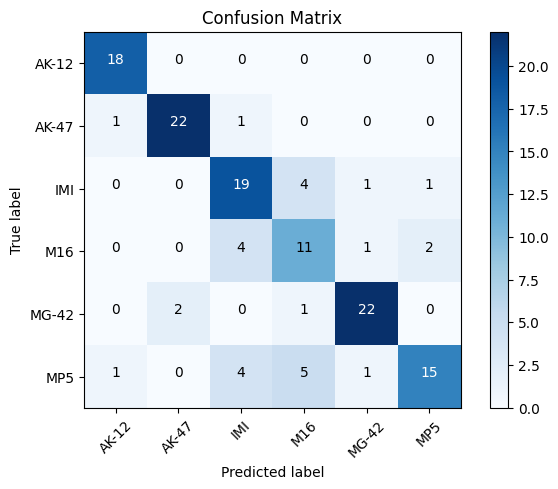

In [133]:
cm_plot_labels=['AK-12','AK-47','IMI','M16','MG-42','MP5']
plot_confusion_matrix(cm=cm,classes=cm_plot_labels,title='Confusion Matrix')

In [138]:
from sklearn.metrics import f1_score
f1_score(y_actual, y_pred, average='macro')

0.7844894942859194